In [7]:
from math import log2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pylab as plt
import pandas as pd
import pickle

import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from torchvision.io import read_image

%matplotlib inline

In [2]:
START_TRAIN_IMG_SIZE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 1e-3
BATCH_SIZES = [256,256,128,64,32,16]
CHANNELS_IMG = 3
Z_DIM = 512
W_DIM = 512
IN_CHANNELS = 512
LAMBDA_GP = 10
PROGRESSIVE_EPOCHS = [30] * len(BATCH_SIZES)

DATASETROOT = "./"

In [3]:
class FFHQDataset(Dataset):
    """ Dataset to load FFHQ data from a dataframe

    Args:

        dataframe : dataframe with image paths in column 'image_path'
        datasetRoot : the root path to join before the image_path, if any.
        res : resolution of the image generated
    
    """
    def __init__(self, dataframe, datasetRoot, transform, res = 2, device = "cuda:0") -> None:
        super().__init__()
        self.dataframe = dataframe
        self.datasetRoot = datasetRoot
        self.res = res
        self.device = torch.device(device)

        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index) :
        img_path = os.path.join(self.datasetRoot,self.dataframe['image_path'].iloc[index])
        image = read_image(img_path)
        return self.transform(image).to(self.device)

In [4]:
def process_filepath(x):
    x = x.split("/")
    x.pop(1)
    return "/".join(x)


data = pd.read_json(os.path.join(DATASETROOT,"ffhq-dataset-v2.json"),orient="index")
data['image_path'] = data.apply(lambda x : process_filepath(x['thumbnail']['file_path']),axis=1)
data = data.drop(columns=['image','thumbnail','in_the_wild','metadata'])


In [5]:
def get_loader(image_size,data,dataType="training") -> DataLoader:
    trainsform = transforms.Compose(
        [transforms.ToPILImage(),
         transforms.Resize((image_size, image_size)),
         transforms.ToTensor(),
         transforms.RandomHorizontalFlip(p=0.5),
         transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)],
            [0.5 for _ in range(CHANNELS_IMG)],
         )
        ]
    )

    data = data.loc[data['category']==dataType].drop(columns=['category'])

    batch_size = BATCH_SIZES[int(log2(image_size/4))]
    dataset  = FFHQDataset(data, DATASETROOT,trainsform, image_size)
    return DataLoader(dataset,batch_size=batch_size, shuffle= True), dataset

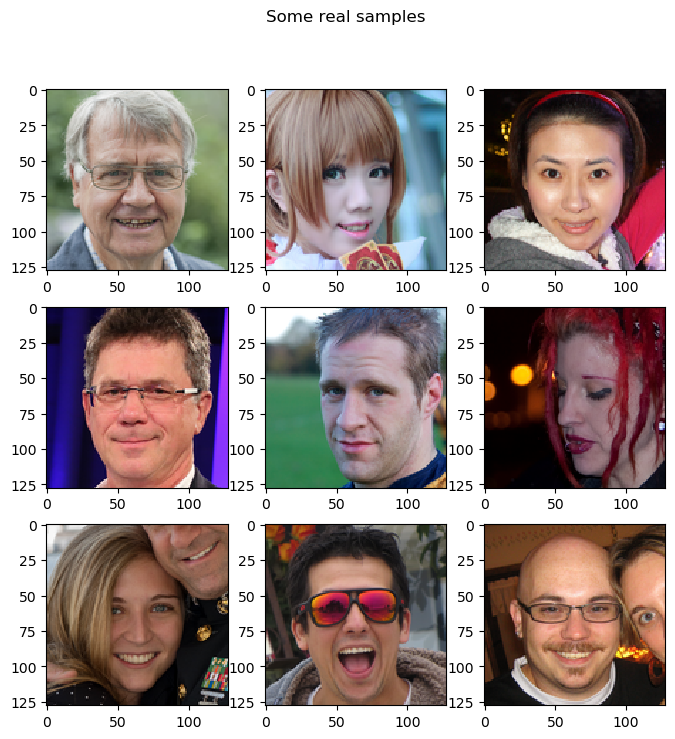

In [9]:
def check_loader():
    loader,_ = get_loader(128,data)
    img  = next(iter(loader))
    img = img.cpu().detach()
    _,ax     = plt.subplots(3,3,figsize=(8,8))
    plt.suptitle('Some real samples')
    ind = 0
    for k in range(3):
        for kk in range(3):
            ax[k][kk].imshow((img[ind].permute(1,2,0)+1)/2)
            ind +=1
    plt.show()
check_loader() 

In [10]:
factors = [1,1,1,1/2,1/4,1/8,1/16,1/32]

In [11]:
class WSLinear(nn.Module):
    def __init__(
        self, in_features, out_features
    ):
        super(WSLinear,self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.scale  = (2/in_features) ** 0.5
        self.bias   = self.linear.bias
        self.linear.bias = None

        nn.init.normal_(self.linear.weight)
        nn.init.zeros_(self.bias)

    def forward(self,x):
        return self.linear(x * self.scale) + self.bias


class PixenNorm(nn.Module):
    def __init__(self):
        super(PixenNorm, self).__init__()
        self.epsilon = 1e-8
    def forward(self,x ):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True)+  self.epsilon)

class MappingNetwork(nn.Module):
    def __init__(self, z_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            PixenNorm(),
            WSLinear(z_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
        )
    
    def forward(self,x):
        return self.mapping(x)

class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.style_scale   = WSLinear(w_dim, channels)
        self.style_bias    = WSLinear(w_dim, channels)

    def forward(self,x,w):
        x = self.instance_norm(x)
        style_scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)
        style_bias  = self.style_bias(w).unsqueeze(2).unsqueeze(3)
        return style_scale * x + style_bias

class injectNoise(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1,channels,1,1))

    def forward(self, x):
        noise = torch.randn((x.shape[0], 1, x.shape[2], x.shape[3]), device = x.device)
        return x + self.weight + noise

class WSConv2d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.leaky(self.conv2(x))
        return x

In [12]:
class GenBlock(nn.Module):
    def __init__(self, in_channel, out_channel, w_dim):
        super(GenBlock, self).__init__()
        self.conv1 = WSConv2d(in_channel, out_channel)
        self.conv2 = WSConv2d(out_channel, out_channel)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)
        self.inject_noise1 = injectNoise(out_channel)
        self.inject_noise2 = injectNoise(out_channel)
        self.adain1 = AdaIN(out_channel, w_dim)
        self.adain2 = AdaIN(out_channel, w_dim)
    def forward(self, x,w):
        x = self.adain1(self.leaky(self.inject_noise1(self.conv1(x))), w)
        x = self.adain2(self.leaky(self.inject_noise2(self.conv2(x))), w)
        return x

class Generator(nn.Module):
    def __init__(self, z_dim, w_dim, in_channels, img_channels=3):
        super().__init__()
        self.starting_cte = nn.Parameter(torch.ones(1, in_channels, 4,4))
        self.map = MappingNetwork(z_dim, w_dim)
        self.initial_adain1 = AdaIN(in_channels, w_dim)
        self.initial_adain2 = AdaIN(in_channels, w_dim)
        self.initial_noise1 = injectNoise(in_channels)
        self.initial_noise2 = injectNoise(in_channels)
        self.initial_conv   = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.leaky          = nn.LeakyReLU(0.2, inplace=True)

        self.initial_rgb    = WSConv2d(
            in_channels, img_channels, kernel_size = 1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb])
        )

        for i in range(len(factors)-1):
            conv_in_c  = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i+1])
            self.prog_blocks.append(GenBlock(conv_in_c, conv_out_c, w_dim))
            self.rgb_layers.append(WSConv2d(conv_out_c, img_channels, kernel_size = 1, stride=1, padding=0))
        
    def fade_in(self, alpha, upscaled, generated):
        return torch.tanh(alpha * generated + (1-alpha ) * upscaled)

    def forward(self, noise, alpha, steps):
        w = self.map(noise)
        x = self.initial_adain1(self.initial_noise1(self.starting_cte),w)
        x = self.initial_conv(x)
        out = self.initial_adain2(self.leaky(self.initial_noise2(x)), w)

        if steps == 0:
            return self.initial_rgb(x)
        
        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode = 'bilinear')
            out      = self.prog_blocks[step](upscaled,w)

        final_upscaled = self.rgb_layers[steps-1](upscaled)
        final_out      = self.rgb_layers[steps](out)

        return self.fade_in(alpha, final_upscaled, final_out)

In [13]:

class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

In [14]:
def generate_examples(gen, steps, n=100):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, Z_DIM).to(DEVICE)
            img = gen(noise, alpha, steps)
            if not os.path.exists(f'saved_examples/step{steps}'):
                os.makedirs(f'saved_examples/step{steps}')
            save_image(img*0.5+0.5, f"saved_examples/step{steps}/img_{i}.png")
    gen.train()


In [15]:
def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)
 
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen
):
    loop = tqdm(loader, leave=True)

    for batch_idx, real in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]
        noise = torch.randn(cur_batch_size, Z_DIM).to(DEVICE)
        fake  = gen(noise, alpha, step)
        critic_real = critic(real, alpha, step)
        critic_fake = critic(fake.detach(), alpha, step)
        gp = gradient_penalty(critic, real, fake, alpha, step, DEVICE)
        loss_critic = (
            -(torch.mean(critic_real) - torch.mean(critic_fake))
            + LAMBDA_GP * gp
            + (0.001) * torch.mean(critic_real ** 2)
        )

        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        alpha += cur_batch_size / (
            PROGRESSIVE_EPOCHS[step] * 0.5 * len(dataset)
        )
        alpha = min(alpha,1)


        loop.set_postfix(
            gp = gp.item(),
            loss_critic = loss_critic.item()
        )
    return alpha


In [ ]:
gen = Generator(
    Z_DIM, W_DIM, IN_CHANNELS, CHANNELS_IMG
).to(DEVICE)
critic = Discriminator(IN_CHANNELS, CHANNELS_IMG).to(DEVICE)
opt_gen = optim.Adam([{'params': [param for name, param in gen.named_parameters() if 'map' not in name]},
                     {'params': gen.map.parameters(), 'lr': 1e-5}], lr=LR, betas =(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr= LR, betas =(0.0, 0.99)
)

gen.train()
critic.train()
step = int(log2(START_TRAIN_IMG_SIZE / 4))
for num_epochs in PROGRESSIVE_EPOCHS[step:]:
    alpha = 1e-7
    loader, dataset = get_loader(4*2**step, data)
    print('Curent image size: '+str(4*2**step))

    for epoch in range(num_epochs):
        print(f'Epoch [{epoch + 1}/ {num_epochs}')
        alpha = train_fn(
            critic, gen, loader, dataset, step, alpha, opt_critic, opt_gen
        )
    generate_examples(gen, step)
    step +=1



Curent image size: 4
Epoch [1/ 30


100%|████████████| 235/235 [02:26<00:00,  1.60it/s, gp=0.595, loss_critic=-15.7]


Epoch [2/ 30


100%|██████████████| 235/235 [02:01<00:00,  1.94it/s, gp=0.484, loss_critic=-15]


Epoch [3/ 30


100%|█████████████| 235/235 [02:05<00:00,  1.88it/s, gp=0.31, loss_critic=-15.3]


Epoch [4/ 30


100%|████████████| 235/235 [02:05<00:00,  1.87it/s, gp=0.347, loss_critic=-11.5]


Epoch [5/ 30


100%|█████████████| 235/235 [02:07<00:00,  1.84it/s, gp=0.151, loss_critic=-9.4]


Epoch [6/ 30


100%|███████████| 235/235 [02:04<00:00,  1.89it/s, gp=0.0788, loss_critic=-7.02]


Epoch [7/ 30


100%|███████████| 235/235 [02:02<00:00,  1.92it/s, gp=0.0584, loss_critic=-3.91]


Epoch [8/ 30


100%|███████████| 235/235 [02:03<00:00,  1.90it/s, gp=0.0875, loss_critic=-4.43]


Epoch [9/ 30


100%|███████████| 235/235 [02:02<00:00,  1.91it/s, gp=0.0195, loss_critic=-1.93]


Epoch [10/ 30


100%|███████████| 235/235 [02:04<00:00,  1.89it/s, gp=0.0213, loss_critic=-1.25]


Epoch [11/ 30


100%|███████████| 235/235 [02:07<00:00,  1.85it/s, gp=0.0139, loss_critic=-.473]


Epoch [12/ 30


100%|██████████| 235/235 [02:12<00:00,  1.77it/s, gp=0.00999, loss_critic=-.957]


Epoch [13/ 30


100%|███████████| 235/235 [02:01<00:00,  1.93it/s, gp=0.00876, loss_critic=-.25]


Epoch [14/ 30


100%|████████████| 235/235 [02:02<00:00,  1.92it/s, gp=0.011, loss_critic=-.115]


Epoch [15/ 30


100%|███████████| 235/235 [02:03<00:00,  1.90it/s, gp=0.0095, loss_critic=-.139]


Epoch [16/ 30


100%|█████████| 235/235 [02:00<00:00,  1.94it/s, gp=0.00757, loss_critic=-.0936]


Epoch [17/ 30


100%|█████████| 235/235 [02:01<00:00,  1.93it/s, gp=0.00572, loss_critic=-.0551]


Epoch [18/ 30


100%|██████████| 235/235 [02:02<00:00,  1.93it/s, gp=0.00602, loss_critic=-.152]


Epoch [19/ 30


100%|██████████| 235/235 [02:10<00:00,  1.80it/s, gp=0.00631, loss_critic=-.154]


Epoch [20/ 30


100%|██████████| 235/235 [02:03<00:00,  1.90it/s, gp=0.00539, loss_critic=-.206]


Epoch [21/ 30


100%|█████████| 235/235 [02:02<00:00,  1.92it/s, gp=0.00597, loss_critic=-.0534]


Epoch [22/ 30


100%|██████████| 235/235 [02:03<00:00,  1.91it/s, gp=0.00361, loss_critic=-.127]


Epoch [23/ 30


100%|█████████| 235/235 [02:02<00:00,  1.92it/s, gp=0.00437, loss_critic=-.0677]


Epoch [24/ 30


100%|█████████████| 235/235 [02:03<00:00,  1.91it/s, gp=0.0035, loss_critic=-.2]


Epoch [25/ 30


100%|██████████| 235/235 [02:02<00:00,  1.92it/s, gp=0.00482, loss_critic=-.121]


Epoch [26/ 30


100%|███████████| 235/235 [02:03<00:00,  1.90it/s, gp=0.0054, loss_critic=-.185]


Epoch [27/ 30


100%|██████████| 235/235 [02:02<00:00,  1.91it/s, gp=0.00568, loss_critic=-.112]


Epoch [28/ 30


100%|██████████| 235/235 [02:03<00:00,  1.91it/s, gp=0.00535, loss_critic=0.037]


Epoch [29/ 30


100%|█████████| 235/235 [02:03<00:00,  1.91it/s, gp=0.00521, loss_critic=-.0761]


Epoch [30/ 30


100%|████████████| 235/235 [02:02<00:00,  1.92it/s, gp=0.005, loss_critic=-.141]


Curent image size: 8
Epoch [1/ 30


100%|█████████| 235/235 [02:45<00:00,  1.42it/s, gp=0.00895, loss_critic=0.0453]


Epoch [2/ 30


100%|██████████| 235/235 [02:44<00:00,  1.43it/s, gp=0.00707, loss_critic=-.273]


Epoch [3/ 30


100%|██████████| 235/235 [02:44<00:00,  1.43it/s, gp=0.00518, loss_critic=-.255]


Epoch [4/ 30


100%|██████████| 235/235 [02:43<00:00,  1.44it/s, gp=0.00373, loss_critic=-.207]


Epoch [5/ 30


100%|██████████| 235/235 [02:43<00:00,  1.43it/s, gp=0.00374, loss_critic=-.349]


Epoch [6/ 30


100%|██████████| 235/235 [02:46<00:00,  1.41it/s, gp=0.00552, loss_critic=-.528]


Epoch [7/ 30


100%|███████████| 235/235 [02:46<00:00,  1.41it/s, gp=0.0155, loss_critic=-.509]


Epoch [8/ 30


100%|███████████| 235/235 [02:46<00:00,  1.42it/s, gp=0.00598, loss_critic=-.52]


Epoch [9/ 30


100%|███████████| 235/235 [02:46<00:00,  1.41it/s, gp=0.0118, loss_critic=-.389]


Epoch [10/ 30


100%|███████████| 235/235 [02:46<00:00,  1.41it/s, gp=0.0133, loss_critic=-.425]


Epoch [11/ 30


100%|██████████| 235/235 [02:45<00:00,  1.42it/s, gp=0.00768, loss_critic=-.423]


Epoch [12/ 30


100%|███████████| 235/235 [02:45<00:00,  1.42it/s, gp=0.0338, loss_critic=0.148]


Epoch [13/ 30


100%|███████████| 235/235 [02:45<00:00,  1.42it/s, gp=0.00925, loss_critic=-.57]


Epoch [14/ 30


100%|███████████| 235/235 [02:44<00:00,  1.43it/s, gp=0.0191, loss_critic=-.123]


Epoch [15/ 30


100%|███████████| 235/235 [02:51<00:00,  1.37it/s, gp=0.0148, loss_critic=-.657]


Epoch [16/ 30


100%|███████████| 235/235 [02:48<00:00,  1.40it/s, gp=0.0181, loss_critic=-.426]


Epoch [17/ 30


100%|███████████| 235/235 [02:47<00:00,  1.40it/s, gp=0.0421, loss_critic=-.226]


Epoch [18/ 30


100%|██████████| 235/235 [02:49<00:00,  1.39it/s, gp=0.00786, loss_critic=-.538]


Epoch [19/ 30


100%|██████████| 235/235 [02:46<00:00,  1.41it/s, gp=0.00866, loss_critic=-.345]


Epoch [20/ 30


100%|███████████| 235/235 [02:47<00:00,  1.41it/s, gp=0.0196, loss_critic=-.528]


Epoch [21/ 30


100%|██████████| 235/235 [02:44<00:00,  1.43it/s, gp=0.00763, loss_critic=-.251]


Epoch [22/ 30


100%|██████████| 235/235 [02:48<00:00,  1.40it/s, gp=0.00724, loss_critic=-.159]


Epoch [23/ 30


100%|██████████| 235/235 [02:47<00:00,  1.40it/s, gp=0.00406, loss_critic=-.205]


Epoch [24/ 30


100%|██████████| 235/235 [02:45<00:00,  1.42it/s, gp=0.00719, loss_critic=-.161]


Epoch [25/ 30


100%|███████████| 235/235 [02:47<00:00,  1.41it/s, gp=0.0109, loss_critic=-.186]


Epoch [26/ 30


100%|██████████| 235/235 [02:47<00:00,  1.41it/s, gp=0.00564, loss_critic=-.276]


Epoch [27/ 30


100%|██████████| 235/235 [02:47<00:00,  1.40it/s, gp=0.00869, loss_critic=-.433]


Epoch [28/ 30


100%|█████████| 235/235 [02:49<00:00,  1.39it/s, gp=0.0101, loss_critic=-.00734]


Epoch [29/ 30


100%|███████████| 235/235 [02:47<00:00,  1.40it/s, gp=0.0189, loss_critic=-.181]


Epoch [30/ 30


100%|███████████| 235/235 [02:46<00:00,  1.41it/s, gp=0.0135, loss_critic=0.055]


Curent image size: 16
Epoch [1/ 30


100%|██████████| 469/469 [05:45<00:00,  1.36it/s, gp=0.00576, loss_critic=-.582]


Epoch [2/ 30


100%|██████████| 469/469 [05:44<00:00,  1.36it/s, gp=0.00575, loss_critic=-.644]


Epoch [3/ 30


100%|██████████| 469/469 [05:40<00:00,  1.38it/s, gp=0.00753, loss_critic=-.689]


Epoch [4/ 30


100%|███████████| 469/469 [05:40<00:00,  1.38it/s, gp=0.0044, loss_critic=-.538]


Epoch [5/ 30


100%|██████████| 469/469 [05:40<00:00,  1.38it/s, gp=0.00469, loss_critic=-.609]


Epoch [6/ 30


100%|██████████| 469/469 [05:38<00:00,  1.38it/s, gp=0.00552, loss_critic=-.505]


Epoch [7/ 30


100%|██████████| 469/469 [05:39<00:00,  1.38it/s, gp=0.00487, loss_critic=-.809]


Epoch [8/ 30


100%|██████████| 469/469 [05:40<00:00,  1.38it/s, gp=0.00728, loss_critic=-.438]


Epoch [9/ 30


100%|███████████| 469/469 [05:38<00:00,  1.38it/s, gp=0.0061, loss_critic=-.664]


Epoch [10/ 30


100%|██████████| 469/469 [05:40<00:00,  1.38it/s, gp=0.00513, loss_critic=-.455]


Epoch [11/ 30


100%|███████████| 469/469 [05:40<00:00,  1.38it/s, gp=0.0053, loss_critic=-.592]


Epoch [12/ 30


100%|██████████| 469/469 [05:41<00:00,  1.37it/s, gp=0.00864, loss_critic=-.521]


Epoch [13/ 30


100%|██████████| 469/469 [05:41<00:00,  1.37it/s, gp=0.00513, loss_critic=-.407]


Epoch [14/ 30


100%|███████████| 469/469 [05:42<00:00,  1.37it/s, gp=0.0143, loss_critic=-.655]


Epoch [15/ 30


100%|██████████| 469/469 [05:42<00:00,  1.37it/s, gp=0.00562, loss_critic=-.481]


Epoch [16/ 30


100%|██████████| 469/469 [05:40<00:00,  1.38it/s, gp=0.00286, loss_critic=-.391]


Epoch [17/ 30


100%|██████████| 469/469 [05:40<00:00,  1.38it/s, gp=0.00885, loss_critic=-.128]


Epoch [18/ 30


100%|██████████| 469/469 [05:47<00:00,  1.35it/s, gp=0.00925, loss_critic=-.407]


Epoch [19/ 30


100%|██████████| 469/469 [05:42<00:00,  1.37it/s, gp=0.00438, loss_critic=-.319]


Epoch [20/ 30


100%|████████████| 469/469 [05:38<00:00,  1.39it/s, gp=0.0041, loss_critic=-.36]


Epoch [21/ 30


100%|██████████| 469/469 [05:40<00:00,  1.38it/s, gp=0.00344, loss_critic=-.349]


Epoch [22/ 30


100%|███████████| 469/469 [05:43<00:00,  1.36it/s, gp=0.00525, loss_critic=-.36]


Epoch [23/ 30


100%|██████████| 469/469 [05:39<00:00,  1.38it/s, gp=0.00528, loss_critic=-.228]


Epoch [24/ 30


100%|███████████| 469/469 [05:38<00:00,  1.39it/s, gp=0.0026, loss_critic=-.379]


Epoch [25/ 30


100%|██████████| 469/469 [05:41<00:00,  1.37it/s, gp=0.00285, loss_critic=-.273]


Epoch [26/ 30


100%|███████████| 469/469 [05:40<00:00,  1.38it/s, gp=0.0021, loss_critic=-.293]


Epoch [27/ 30


100%|██████████| 469/469 [05:40<00:00,  1.38it/s, gp=0.00513, loss_critic=-.375]


Epoch [28/ 30


100%|██████████| 469/469 [05:40<00:00,  1.38it/s, gp=0.00348, loss_critic=-.193]


Epoch [29/ 30


100%|██████████| 469/469 [05:42<00:00,  1.37it/s, gp=0.00424, loss_critic=-.266]


Epoch [30/ 30


100%|██████████| 469/469 [05:46<00:00,  1.35it/s, gp=0.00283, loss_critic=-.254]


Curent image size: 32
Epoch [1/ 30


100%|██████████| 938/938 [13:50<00:00,  1.13it/s, gp=0.00742, loss_critic=-1.41]


Epoch [2/ 30


100%|██████████| 938/938 [13:47<00:00,  1.13it/s, gp=0.00388, loss_critic=-.906]


Epoch [3/ 30


100%|██████████| 938/938 [14:09<00:00,  1.10it/s, gp=0.00712, loss_critic=-.884]


Epoch [4/ 30


100%|██████████| 938/938 [13:49<00:00,  1.13it/s, gp=0.00654, loss_critic=-.165]


Epoch [5/ 30


100%|██████████| 938/938 [13:48<00:00,  1.13it/s, gp=0.00885, loss_critic=-.261]


Epoch [6/ 30


100%|███████████| 938/938 [13:46<00:00,  1.14it/s, gp=0.0155, loss_critic=-.137]


Epoch [7/ 30


100%|██████████| 938/938 [13:46<00:00,  1.13it/s, gp=0.00484, loss_critic=-.776]


Epoch [8/ 30


100%|██████████| 938/938 [13:47<00:00,  1.13it/s, gp=0.00617, loss_critic=-.248]


Epoch [9/ 30


100%|██████████| 938/938 [13:50<00:00,  1.13it/s, gp=0.00268, loss_critic=-.716]


Epoch [10/ 30


100%|██████████| 938/938 [13:49<00:00,  1.13it/s, gp=0.00572, loss_critic=-.381]


Epoch [11/ 30


100%|██████████| 938/938 [13:49<00:00,  1.13it/s, gp=0.00964, loss_critic=-.823]


Epoch [12/ 30


100%|██████████| 938/938 [13:49<00:00,  1.13it/s, gp=0.00187, loss_critic=-.533]


Epoch [13/ 30


100%|██████████| 938/938 [13:50<00:00,  1.13it/s, gp=0.00279, loss_critic=-.374]


Epoch [14/ 30


100%|██████████| 938/938 [13:47<00:00,  1.13it/s, gp=0.00322, loss_critic=-.424]


Epoch [15/ 30


100%|███████████| 938/938 [13:46<00:00,  1.13it/s, gp=0.0075, loss_critic=-.328]


Epoch [16/ 30


100%|██████████| 938/938 [13:46<00:00,  1.13it/s, gp=0.00354, loss_critic=-.399]


Epoch [17/ 30


100%|██████████| 938/938 [13:43<00:00,  1.14it/s, gp=0.00414, loss_critic=-.402]


Epoch [18/ 30


100%|██████████| 938/938 [13:38<00:00,  1.15it/s, gp=0.00508, loss_critic=-.286]


Epoch [19/ 30


100%|██████████| 938/938 [13:40<00:00,  1.14it/s, gp=0.00148, loss_critic=-.807]


Epoch [20/ 30


100%|██████████| 938/938 [13:42<00:00,  1.14it/s, gp=0.00389, loss_critic=-.309]


Epoch [21/ 30


100%|██████████| 938/938 [13:42<00:00,  1.14it/s, gp=0.00249, loss_critic=-.478]


Epoch [22/ 30


100%|██████████| 938/938 [13:42<00:00,  1.14it/s, gp=0.00166, loss_critic=-.503]


Epoch [23/ 30


100%|██████████| 938/938 [13:44<00:00,  1.14it/s, gp=0.00258, loss_critic=-.517]


Epoch [24/ 30


100%|██████████| 938/938 [13:37<00:00,  1.15it/s, gp=0.00118, loss_critic=-.197]


Epoch [25/ 30


100%|██████████| 938/938 [13:36<00:00,  1.15it/s, gp=0.00167, loss_critic=-.684]


Epoch [26/ 30


100%|██████████| 938/938 [13:37<00:00,  1.15it/s, gp=0.00423, loss_critic=-.437]


Epoch [27/ 30


100%|██████████| 938/938 [13:37<00:00,  1.15it/s, gp=0.00406, loss_critic=-.356]


Epoch [28/ 30


100%|████████████| 938/938 [13:38<00:00,  1.15it/s, gp=0.00536, loss_critic=-.2]


Epoch [29/ 30


100%|██████████| 938/938 [13:40<00:00,  1.14it/s, gp=0.00266, loss_critic=-.627]


Epoch [30/ 30


100%|██████████| 938/938 [13:41<00:00,  1.14it/s, gp=0.00314, loss_critic=-.406]


Curent image size: 64
Epoch [1/ 30


100%|█████████| 1875/1875 [26:28<00:00,  1.18it/s, gp=0.0174, loss_critic=-1.78]


Epoch [2/ 30


100%|█████████| 1875/1875 [26:21<00:00,  1.19it/s, gp=0.0172, loss_critic=-1.07]


Epoch [3/ 30


100%|██████████| 1875/1875 [26:19<00:00,  1.19it/s, gp=0.007, loss_critic=-1.74]


Epoch [4/ 30


100%|█████████| 1875/1875 [26:24<00:00,  1.18it/s, gp=0.0121, loss_critic=-1.78]


Epoch [5/ 30


100%|████████| 1875/1875 [26:26<00:00,  1.18it/s, gp=0.00547, loss_critic=-1.11]


Epoch [6/ 30


100%|█████████| 1875/1875 [26:26<00:00,  1.18it/s, gp=0.0123, loss_critic=0.508]


Epoch [7/ 30


100%|█████████| 1875/1875 [26:24<00:00,  1.18it/s, gp=0.00956, loss_critic=-.38]


Epoch [8/ 30


100%|█████████| 1875/1875 [26:20<00:00,  1.19it/s, gp=0.0155, loss_critic=-2.25]


Epoch [9/ 30


100%|████████| 1875/1875 [26:22<00:00,  1.19it/s, gp=0.00891, loss_critic=-1.17]


Epoch [10/ 30


100%|████████| 1875/1875 [26:32<00:00,  1.18it/s, gp=0.00319, loss_critic=-1.17]


Epoch [11/ 30


100%|████████| 1875/1875 [26:23<00:00,  1.18it/s, gp=0.00372, loss_critic=-1.28]


Epoch [12/ 30


100%|████████| 1875/1875 [26:27<00:00,  1.18it/s, gp=0.00358, loss_critic=-1.08]


Epoch [13/ 30


100%|████████| 1875/1875 [26:20<00:00,  1.19it/s, gp=0.00387, loss_critic=-.876]


Epoch [14/ 30


100%|████████| 1875/1875 [26:18<00:00,  1.19it/s, gp=0.00621, loss_critic=-.954]


Epoch [15/ 30


100%|█████████| 1875/1875 [26:23<00:00,  1.18it/s, gp=0.0084, loss_critic=-.624]


Epoch [16/ 30


100%|█████████| 1875/1875 [26:24<00:00,  1.18it/s, gp=0.0188, loss_critic=-.484]


Epoch [17/ 30


100%|████████| 1875/1875 [26:27<00:00,  1.18it/s, gp=0.00893, loss_critic=-.564]


Epoch [18/ 30


100%|█████████| 1875/1875 [26:29<00:00,  1.18it/s, gp=0.0138, loss_critic=-1.06]


Epoch [19/ 30


100%|████████| 1875/1875 [26:45<00:00,  1.17it/s, gp=0.00532, loss_critic=-.414]


Epoch [20/ 30


100%|████████| 1875/1875 [26:40<00:00,  1.17it/s, gp=0.00462, loss_critic=-.846]


Epoch [21/ 30


100%|████████| 1875/1875 [26:35<00:00,  1.18it/s, gp=0.00613, loss_critic=-.989]


Epoch [22/ 30


100%|████████| 1875/1875 [26:37<00:00,  1.17it/s, gp=0.00968, loss_critic=-.231]


Epoch [23/ 30


100%|████████| 1875/1875 [26:50<00:00,  1.16it/s, gp=0.00602, loss_critic=-.806]


Epoch [24/ 30


100%|███████| 1875/1875 [26:42<00:00,  1.17it/s, gp=0.00516, loss_critic=-.0196]


Epoch [25/ 30


100%|████████| 1875/1875 [26:31<00:00,  1.18it/s, gp=0.00369, loss_critic=-.734]


Epoch [26/ 30


100%|████████| 1875/1875 [26:31<00:00,  1.18it/s, gp=0.00341, loss_critic=-.988]


Epoch [27/ 30


100%|████████| 1875/1875 [26:38<00:00,  1.17it/s, gp=0.00421, loss_critic=-.918]


Epoch [28/ 30


100%|████████| 1875/1875 [26:38<00:00,  1.17it/s, gp=0.00566, loss_critic=-.801]


Epoch [29/ 30


100%|████████| 1875/1875 [26:35<00:00,  1.18it/s, gp=0.00872, loss_critic=-.251]


Epoch [30/ 30


100%|████████| 1875/1875 [26:33<00:00,  1.18it/s, gp=0.0026, loss_critic=0.0397]


Curent image size: 128
Epoch [1/ 30


100%|████████| 3750/3750 [48:16<00:00,  1.29it/s, gp=0.00777, loss_critic=-3.21]


Epoch [2/ 30


100%|████████| 3750/3750 [48:49<00:00,  1.28it/s, gp=0.00821, loss_critic=-2.97]


Epoch [3/ 30


 84%|██████▊ | 3168/3750 [39:56<07:09,  1.35it/s, gp=0.00229, loss_critic=-.929]